# Прогнозирование оттока клиентов оператора связи «ТелеДом»

# Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

# Описание услуг

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (`DSL`, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (`Fiber optic`).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (`DeviceProtection`) и блокировка небезопасных сайтов (`OnlineSecurity`);
- Выделенная линия технической поддержки (`TechSupport`);
- Облачное хранилище файлов для резервного копирования данных (`OnlineBackup`);
- Стриминговое телевидение (`StreamingTV`) и каталог фильмов (`StreamingMovies`).


Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

# Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Файл `contract_new.csv`:

- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

Файл `personal_new.csv`:
- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

Файл `internet_new.csv`:
- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

Файл `phone_new.csv`:
- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года. Данные также находятся в тренажёре, в папке `/datasets/`.

# Цель работы

In [1]:
#!pip3 install phik==0.10.0
#!pip3 install prettytable

In [2]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns

from catboost import CatBoostClassifier

from prettytable import PrettyTable

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, make_scorer, accuracy_score, 
                             f1_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
STATE = np.random.RandomState(290124)

## Загрузка данных

In [4]:
try:
    df_contract = pd.read_csv('/datasets/contract_new.csv')
except:
    df_contract = pd.read_csv('/contract_new.csv')
df_contract.info()
df_contract.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
649,3509-GWQGF,2018-02-01,No,Month-to-month,No,Credit card (automatic),70.00,1831.2
6669,3588-WSTTJ,2017-03-01,No,Month-to-month,Yes,Electronic check,99.05,3466.75
5079,2507-QZPQS,2018-11-01,No,Month-to-month,No,Electronic check,95.70,1521.63
1755,1803-BGNBD,2019-02-01,No,Month-to-month,Yes,Electronic check,54.30,684.18
6367,0848-SOMKO,2014-04-01,No,Two year,No,Bank transfer (automatic),48.40,3625.16


In [5]:
try:
    df_personal = pd.read_csv('/datasets/personal_new.csv')
except:
    df_personal = pd.read_csv('/personal_new.csv')
df_personal.info()
df_personal.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
5990,1472-TNCWL,Male,0,No,Yes
4296,4489-SNOJF,Female,0,Yes,Yes
6294,6615-ZGEDR,Male,0,No,No
2520,5788-YPOEG,Female,0,Yes,Yes
1354,9415-DPEWS,Female,0,No,No


In [6]:
try:
    df_internet = pd.read_csv('/datasets/internet_new.csv')
except:
    df_internet = pd.read_csv('/internet_new.csv')
df_internet.info()
df_internet.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4701,9714-EDSUC,Fiber optic,Yes,Yes,No,Yes,No,Yes
3279,7103-ZGVNT,DSL,Yes,Yes,No,Yes,Yes,No
4675,8063-RJYNF,Fiber optic,Yes,No,No,No,Yes,Yes
2878,0836-SEYLU,DSL,No,No,No,Yes,Yes,No
4053,1902-XBTFB,Fiber optic,No,Yes,Yes,No,Yes,No


In [7]:
try:
    df_phone = pd.read_csv('/datasets/phone_new.csv')
except:
    df_phone = pd.read_csv('/phone_new.csv')
df_phone.info()
df_phone.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
863,5382-SOYZL,Yes
2234,1357-MVDOZ,No
4159,0471-ARVMX,Yes
4360,0366-NQSHS,No
5932,4488-PSYCG,No


**Вывод:**

Загрузили все 4 датасета. Имеются следующие комментарии:
- Во всех датасетах нет единого стиля наименования столбцов;
- По количеству строк совпадают только датафреймы `df_contract` и `df_personal`, в остальных количество строк меньше;
- `df_contract`:
    - *BeginDate* и *EndDate* должны быть в формате `datetime64`;
    - *PaperlessBilling* заменим на формат `int` со значениями `1` и `0`;
    - *TotalCharges* необходимо перевести в формат `float`;
- `df_personal`:
    - *SeniorCitizen*, *Partner* и *Dependents* можно заменить на формат `int` со значениями `1` и `0`;  
- `df_internet`:
    - *OnlineSecurity*, *OnlineBackup*, *DeviceProtection*, *TechSupport*, *StreamingTV* и *StreamingMovies* заменим на формат `int` со значениями `1` и `0`;
- `df_phone`:
    - *MultipleLines* можно заменить на формат `int` со значениями `1` и `0`.
    
Более подробно рассмотрим датасеты ниже.

## Предобработка данных

Для последующей предобработки датафреймов используем несколько функций:

In [8]:
def missing_zero_values_table(df):
    zero_val = (df == 0.00).astype(int).sum(axis=0)
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(
    columns = {0 : 'Нулевые значения', 1 : 'Отсутствующие значения', 2 : '% отсутствующих значений от всех значений'})
    mz_table['Всего нулевых и отсутствующих значений'] = mz_table['Нулевые значения'] + mz_table['Отсутствующие значения']
    mz_table['% всех нулевых и отсутствующих значений'] = 100 * mz_table['Всего нулевых и отсутствующих значений'] / len(df)
    mz_table['Тип столбца'] = df.dtypes
    mz_table = mz_table[
        mz_table.iloc[:,1] != 0].sort_values(
    '% отсутствующих значений от всех значений', ascending=False).round(1)
    print ('\nВ выбранном датафрейме ' + str(df.shape[1]) + ' столбца(-ов) и ' + str(df.shape[0]) + ' строк.\n' \
           + str(mz_table.shape[0]) + ' столбца(-ов) имеют отсутствующие значения.')
        
    return mz_table

In [9]:
def get_info(df, df_name):
    print(f'\nТаблица "{df_name}":')
    print('\nСлучайные 10 строк:')
    display(df.sample(10))
    display(missing_zero_values_table(df))
    print('\nТипы данных полей:')
    display(df.dtypes)

In [10]:
def new_columns(df):
    df = df.rename(columns={'customerID': 'CustomerId'})
    try:
        df = df.rename(columns={'StreamingTV': 'StreamingTv'})
        df = df.rename(columns={'gender': 'Gender'})
    finally:
        df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
        display(df.columns)
    
    return df

### Датафрейм contract_new.csv — информация о договоре

Выведем информацию о датасете:

In [11]:
get_info(df_contract, 'contract')


Таблица "contract":

Случайные 10 строк:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3358,5447-VYTKW,2017-11-01,No,Month-to-month,No,Mailed check,53.45,1443.15
6321,1577-HKTFG,2017-04-01,No,Month-to-month,No,Bank transfer (automatic),19.65,668.1
3680,0836-SEYLU,2019-04-01,No,Month-to-month,No,Mailed check,40.65,439.02
5094,6266-QHOJZ,2014-09-01,No,One year,Yes,Electronic check,89.85,5840.25
3097,2410-CIYFZ,2019-12-01,No,Month-to-month,No,Mailed check,20.40,41.21
2052,2038-LLMLM,2016-02-01,No,Month-to-month,Yes,Electronic check,103.85,4984.8
1187,8089-UZWLX,2014-03-01,No,Two year,No,Bank transfer (automatic),104.05,7904.68
2935,9435-JMLSX,2014-03-01,2018-08-01,Two year,Yes,Bank transfer (automatic),86.10,4882.73
2302,7579-KKLOE,2014-03-01,No,Two year,Yes,Mailed check,91.25,6478.75
5373,4043-MKDTV,2014-03-01,No,Two year,Yes,Electronic check,105.25,7472.75



В выбранном датафрейме 8 столбца(-ов) и 7043 строк.
0 столбца(-ов) имеют отсутствующие значения.


,Нулевые значения,Отсутствующие значения,% отсутствующих значений от всех значений,Всего нулевых и отсутствующих значений,% всех нулевых и отсутствующих значений,Тип столбца



Типы данных полей:


customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

Приведем названия столбцов к единому стилю:

In [12]:
df_contract = new_columns(df_contract)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

Проверим являются все ID в нашем датасете униальными:

In [13]:
df_contract['customer_id'].is_unique

True

Установим `customer_id` в качестве индекса:

In [14]:
df_contract = df_contract.set_index('customer_id')

В столбце `end_date` имеются строки со значением `No`. Рассмотрим, что это за строки и сколько их:

In [15]:
df_contract[df_contract['end_date'] == 'No']

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6


Всего 5942 строки. Это значит, что 5942 абонента еще не расторгли договор на момент скачивания датасета (`2020-02-01`). На основе этой информации сделаем целевой признак `сhurn` для нашей модели. Заменим все значения `No` на дату `2020-02-01` для последующего анализа:

In [16]:
df_contract['churn'] = (df_contract['end_date'] != 'No').astype('int')

In [17]:
df_contract['end_date'] = df_contract['end_date'].replace(['No'], ['2020-02-01'])
df_contract[df_contract['end_date'] == 'No'].shape[0]

0

Изменим тип столбцов `begin_date` и `end_date` на `datetime`:

In [18]:
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format='%Y-%m-%d')
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], format='%Y-%m-%d')

Создадим столбец `total_days` с количеством дней действия контракта для каждого абонента:

In [19]:
df_contract['total_days'] = (df_contract['end_date'] - df_contract['begin_date']).dt.days

Изменим тип столбца `total_charges` на `float` и проверим отсутствующие значения:

In [20]:
df_contract['total_charges'] = pd.to_numeric(df_contract['total_charges'], errors ='coerce')

In [21]:
df_contract[df_contract['total_charges'].isnull()]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,total_days
customer_id,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0


Все 11 абонентов, имеющих значение `NaN` в столбце `total_charges` заключили договор `2020-02-01`. Это день скачивания датасета, т.о. они еще не успели внести платеж. Заменим эти значения на `0`:

In [22]:
df_contract['total_charges'] = df_contract['total_charges'].fillna(0)
df_contract['total_charges'].isnull().sum()

0

**Вывод:** 
- столбец `customer_id` сделали индексом; 
- cоздали целевой признак на основе столбца `end_date`;
- в столбце `end_date` заменили отсутсвующие значения на дату скачивания датасета - `2020-02-01`;
- изметили тип столбцов `begin_date` и `end_date` на `datetime`;
- создали столбец `total_days` обозначающий количество дней действия договора с момента заключения до момента расторжения;
- отсутствующие значения в столбце `total_charges` заменили на `0`.

Датасет подготовлен для дальнейшего анализа.

### Датафрейм personal_new.csv — персональные данные клиента

In [23]:
get_info(df_personal, 'personal')


Таблица "personal":

Случайные 10 строк:


,customerID,gender,SeniorCitizen,Partner,Dependents
4443,2672-OJQZP,Female,0,No,No
362,0104-PPXDV,Male,0,Yes,No
6097,9114-DPSIA,Male,0,Yes,Yes
1823,8496-EJAUI,Male,0,No,No
1566,4751-ERMAN,Male,0,Yes,Yes
1742,5318-IXUZF,Female,0,No,No
4950,6892-EZDTG,Female,0,Yes,No
5210,2794-XIMMO,Male,0,Yes,No
4667,5537-UXXVS,Female,0,Yes,No
6492,9548-LERKT,Male,0,Yes,No



В выбранном датафрейме 5 столбца(-ов) и 7043 строк.
0 столбца(-ов) имеют отсутствующие значения.


,Нулевые значения,Отсутствующие значения,% отсутствующих значений от всех значений,Всего нулевых и отсутствующих значений,% всех нулевых и отсутствующих значений,Тип столбца



Типы данных полей:


customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object

Приведем названия столбцов к единому стилю:

In [24]:
df_personal = new_columns(df_personal)

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

Проверим являются все ID в нашем датасете униальными:

In [25]:
df_personal['customer_id'].is_unique

True

Установим `customer_id` в качестве индекса:

In [26]:
df_personal = df_personal.set_index('customer_id')

В столбце `senior_citizen` заменим все значения `1` на `Yes` и значения `0` на `No` для приведения к единому стилю:

In [27]:
df_personal['senior_citizen'].loc[df_personal['senior_citizen'] == 1] = 'Yes'
df_personal['senior_citizen'].loc[df_personal['senior_citizen'] == 0] = 'No'

**Вывод:**

- столбец `customer_id` сделали индексом; 
- в столбце `senior_citizen` заменили все значения `1` на `Yes` и значения `0` на `No`.

Датасет подготовлен для дальнейшего анализа.

### Датафрейм internet_new.csv — информация об интернет-услугах

In [28]:
get_info(df_internet, 'internet')


Таблица "internet":

Случайные 10 строк:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4783,3896-RCYYE,DSL,No,No,Yes,Yes,Yes,Yes
5438,1564-NTYXF,Fiber optic,No,No,No,No,No,Yes
1814,4813-HQMGZ,Fiber optic,No,No,No,Yes,No,Yes
1059,4791-QRGMF,Fiber optic,No,No,Yes,No,Yes,Yes
2248,1400-WIVLL,Fiber optic,No,No,Yes,Yes,Yes,Yes
4809,3154-CFSZG,Fiber optic,Yes,No,Yes,No,No,Yes
2205,8433-WPJTV,Fiber optic,No,No,Yes,Yes,Yes,Yes
820,8436-BJUMM,Fiber optic,No,No,No,No,Yes,No
3643,3393-FMZPV,Fiber optic,No,Yes,No,No,Yes,Yes
471,3627-FHKBK,Fiber optic,Yes,No,No,No,No,No



В выбранном датафрейме 8 столбца(-ов) и 5517 строк.
0 столбца(-ов) имеют отсутствующие значения.


,Нулевые значения,Отсутствующие значения,% отсутствующих значений от всех значений,Всего нулевых и отсутствующих значений,% всех нулевых и отсутствующих значений,Тип столбца



Типы данных полей:


customerID          object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
dtype: object

Приведем названия столбцов к единому стилю:

In [29]:
df_internet = new_columns(df_internet)

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

Проверим являются все ID в нашем датасете униальными:

In [30]:
df_internet['customer_id'].is_unique

True

Установим `customer_id` в качестве индекса:

In [31]:
df_internet = df_internet.set_index('customer_id')

In [32]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   internet_service   5517 non-null   object
 1   online_security    5517 non-null   object
 2   online_backup      5517 non-null   object
 3   device_protection  5517 non-null   object
 4   tech_support       5517 non-null   object
 5   streaming_tv       5517 non-null   object
 6   streaming_movies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


**Вывод:**

- столбец `customer_id` сделали индексом.

Датасет подготовлен для дальнейшего анализа.

### Датафрейм phone_new.csv — информация об услугах телефонии

In [33]:
get_info(df_phone, 'phone')


Таблица "phone":

Случайные 10 строк:


,customerID,MultipleLines
4583,7762-URZQH,Yes
2191,8231-BSWXX,Yes
5375,0068-FIGTF,No
1801,1024-VRZHF,Yes
4241,7571-YXDAD,Yes
6323,0052-YNYOT,No
3795,7572-KPVKK,Yes
2275,8622-ZLFKO,Yes
1170,8800-ZKRFW,Yes
2466,8150-QUDFX,No



В выбранном датафрейме 2 столбца(-ов) и 6361 строк.
0 столбца(-ов) имеют отсутствующие значения.


,Нулевые значения,Отсутствующие значения,% отсутствующих значений от всех значений,Всего нулевых и отсутствующих значений,% всех нулевых и отсутствующих значений,Тип столбца



Типы данных полей:


customerID       object
MultipleLines    object
dtype: object

Приведем названия столбцов к единому стилю:

In [34]:
df_phone = new_columns(df_phone)

Index(['customer_id', 'multiple_lines'], dtype='object')

Проверим являются все ID в нашем датасете униальными:

In [35]:
df_phone['customer_id'].is_unique

True

Установим `customer_id` в качестве индекса:

In [36]:
df_phone = df_phone.set_index('customer_id')

In [37]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   multiple_lines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


**Вывод:**

- столбец `customer_id` сделали индексом.

Датасет подготовлен для дальнейшего анализа.

### Объединение данных

Объединим все датасеты по индексу:

In [38]:
df = df_contract.merge(df_personal, how='left', on='customer_id') \
                .merge(df_internet, how='left', on='customer_id') \
                .merge(df_phone, how='left', on='customer_id')

In [39]:
get_info(df, 'Объединенный датасет')


Таблица "Объединенный датасет":

Случайные 10 строк:


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,total_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,,,
2834-JRTUA,2013-11-01,2020-02-01,Two year,Yes,Electronic check,108.05,8184.79,0,2283,Male,No,No,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Yes
0356-OBMAC,2015-06-01,2020-02-01,Two year,Yes,Bank transfer (automatic),99.90,5818.18,0,1706,Female,Yes,No,No,Fiber optic,No,Yes,Yes,Yes,Yes,No,Yes
5143-WMWOG,2019-12-01,2020-02-01,Month-to-month,No,Electronic check,19.95,41.50,0,62,Male,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
0575-CUQOV,2015-02-01,2019-08-01,One year,Yes,Electronic check,97.95,5818.23,1,1642,Male,Yes,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
7176-WRTNX,2014-04-01,2018-05-01,Two year,Yes,Bank transfer (automatic),114.95,5801.53,1,1491,Male,No,No,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
1269-FOYWN,2016-06-01,2020-02-01,One year,No,Bank transfer (automatic),20.00,880.00,0,1340,Male,No,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3384-CTMSF,2016-03-01,2020-02-01,Month-to-month,Yes,Electronic check,104.10,4892.70,0,1432,Male,No,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
5315-CKEQK,2017-10-01,2020-02-01,One year,Yes,Electronic check,51.00,1499.40,0,853,Male,Yes,Yes,Yes,DSL,No,No,No,No,No,No,Yes
1635-HDGFT,2018-07-01,2020-02-01,Two year,No,Mailed check,20.50,389.50,0,580,Female,No,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No



В выбранном датафрейме 21 столбца(-ов) и 7043 строк.
8 столбца(-ов) имеют отсутствующие значения.


,Нулевые значения,Отсутствующие значения,% отсутствующих значений от всех значений,Всего нулевых и отсутствующих значений,% всех нулевых и отсутствующих значений,Тип столбца
internet_service,0,1526,21.7,1526,21.7,object
online_security,0,1526,21.7,1526,21.7,object
online_backup,0,1526,21.7,1526,21.7,object
device_protection,0,1526,21.7,1526,21.7,object
tech_support,0,1526,21.7,1526,21.7,object
streaming_tv,0,1526,21.7,1526,21.7,object
streaming_movies,0,1526,21.7,1526,21.7,object
multiple_lines,0,682,9.7,682,9.7,object



Типы данных полей:


begin_date           datetime64[ns]
end_date             datetime64[ns]
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges               float64
churn                         int64
total_days                    int64
gender                       object
senior_citizen               object
partner                      object
dependents                   object
internet_service             object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
multiple_lines               object
dtype: object

В столбце `internet_service` заменим значения `NaN` на значение `No service`:

In [40]:
df['internet_service'] = df['internet_service'].fillna('No service')

Остальные пустые значения заполним `No data` и выведем снова информацию о датасете:

In [41]:
df = df.fillna('No data')
get_info(df, 'Объединенный датасет')


Таблица "Объединенный датасет":

Случайные 10 строк:


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,total_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,,,
4295-YURET,2015-06-01,2020-02-01,Two year,Yes,Credit card (automatic),72.60,4472.16,0,1706,Female,Yes,Yes,Yes,DSL,Yes,No,No,Yes,Yes,Yes,No
1845-ZLLIG,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,50.15,50.15,0,31,Male,No,No,No,DSL,No,Yes,No,No,No,No,No
2458-EOMRE,2019-03-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),64.05,732.73,0,337,Female,No,No,No,DSL,Yes,No,Yes,No,No,Yes,No
1208-NBVFH,2018-06-01,2020-02-01,Month-to-month,Yes,Electronic check,49.60,1021.76,0,610,Male,No,Yes,Yes,DSL,No,No,Yes,No,No,No,No
1735-XMJVH,2019-06-01,2020-02-01,Month-to-month,Yes,Mailed check,19.35,154.80,0,245,Male,No,Yes,Yes,No service,No data,No data,No data,No data,No data,No data,No
8388-DMKAE,2019-06-01,2020-02-01,Two year,No,Mailed check,20.25,168.48,0,245,Female,No,No,No,No service,No data,No data,No data,No data,No data,No data,No
0017-IUDMW,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),116.80,8998.27,0,2191,Female,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
0254-KCJGT,2015-10-01,2017-12-01,One year,Yes,Credit card (automatic),81.40,2201.06,1,792,Male,No,Yes,No,DSL,Yes,Yes,Yes,Yes,No,Yes,Yes
5110-CHOPY,2015-02-01,2020-02-01,Two year,No,Electronic check,53.60,3216.00,0,1826,Female,No,No,No,DSL,Yes,No,Yes,No,Yes,Yes,No data



В выбранном датафрейме 21 столбца(-ов) и 7043 строк.
0 столбца(-ов) имеют отсутствующие значения.


,Нулевые значения,Отсутствующие значения,% отсутствующих значений от всех значений,Всего нулевых и отсутствующих значений,% всех нулевых и отсутствующих значений,Тип столбца



Типы данных полей:


begin_date           datetime64[ns]
end_date             datetime64[ns]
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges               float64
churn                         int64
total_days                    int64
gender                       object
senior_citizen               object
partner                      object
dependents                   object
internet_service             object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
multiple_lines               object
dtype: object

**Вывод:**

- столбец `customer_id` сделали индексом; 
- cоздали целевой признак на основе столбца `end_date`;
- в столбце `end_date` заменили отсутсвующие значения на дату скачивания датасета - `2020-02-01`;
- изметили тип столбцов `begin_date` и `end_date` на `datetime`;
- создали столбец `total_days` обозначающий количество дней действия договора с момента заключения до момента расторжения;
- отсутствующие значения в столбце `total_charges` заменили на `0`;
- в столбце `senior_citizen` заменили все значения `1` на `Yes` и значения `0` на `No`;
- объединили все 4 датасета в 1 на основе индексов;
- отсутствующие значения в столбце `internet_service` заменили на значение `No service`;
- в остальных столбцах заменили отсутствующие значения на `No data`.

Датасет подготовлен для дальнейшего анализа.

## Исследовательский анализ

Для последующей анализа используем несколько функций:

In [42]:
def graf_cat_info(df, cat_col):
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Распределение категориальных данных', fontsize=15)
    
    if cols == 1:
        axs = [axs]

    for col, ax in zip(cat_col, axs):
        x = df[col].value_counts().index
        y = df[col].value_counts().values

        sns.barplot(x=x, y=y, ax=ax)
        ax.set_title(f'Столбец "{col}"')
        ax.set_ylabel('Количество')
        ax.grid(False)
        ax.tick_params(axis='x', labelrotation=45, labelsize=12)

    plt.show()

In [43]:
def box_num_info(df, num_col, titl=''):
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    plt.suptitle(f'Распределение числовых данных "boxplot"{titl}', fontsize=15)

    for col, ax in zip(num_col, axs):
        sns.boxplot(data=df, y=col, ax=ax)
        ax.set_title(f'Столбец "{col}"', fontsize=14)
        ax.set_ylabel('', fontsize=12)
        ax.grid(False)

    plt.show()

In [44]:
def hist_num_info(df, num_col, hue=None):
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    plt.suptitle('Распределение числовых данных "histplot"', fontsize=15)

    for col, ax in zip(num_col, axs):
        sns.histplot(data=df, x=col, ax=ax, hue=hue, kde=True)
        ax.set_title(f'Столбец "{col}"', fontsize=14)
        ax.set_ylabel('Количество', fontsize=12)
        ax.set_xlabel('', fontsize=12)
        ax.grid(False)

    plt.show()

In [45]:
def graf_num_info(df, cat_col, titl=''):
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f'Распределение числовых данных на основе столбца "internet_service"{titl}', fontsize=15)

    for col, ax in zip(cat_col, axs):
        pivot_t = df.pivot_table(index='internet_service', values=col, aggfunc='mean').reset_index()

        pivot_t.plot(x='internet_service', y=col, kind='bar', legend=False, ax=ax)

        ax.set_title(f'Столбец "{col}"')
        ax.set_ylabel('Количество', fontsize=12)
        ax.set_xlabel('Тип интернет-подключения', fontsize=12)
        ax.grid(False)
        ax.tick_params(axis='x', labelrotation=45, labelsize=12)

    plt.show()

In [46]:
def churn_cat_info(df, cat_col):
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Распределение категориальных данных на основе столбца "churn"', fontsize=15)

    for col, ax in zip(cat_col, axs):
        grouped_df = df.groupby([col, 'churn'])['churn'].count()
        grouped_df = grouped_df.unstack()

        bottom = np.zeros(2)
        for value in grouped_df.T.columns[0:]: 
            ax.bar(grouped_df.T.index, grouped_df.T[value], bottom=bottom, label=value)
            bottom += np.array(grouped_df.T[value])
        ax.set_title(f'Столбец "{col}"')
        ax.legend()
        ax.set_ylabel('Количество')
        ax.grid(False)

    plt.show()

### Анализ данных объединенного датафрейма

#### Анализ категориальных признаков

Выберем столбцы с категориальными данными и выведем графики:

In [47]:
cat_columns = df.select_dtypes(include='object').columns.to_list()
#cat_columns

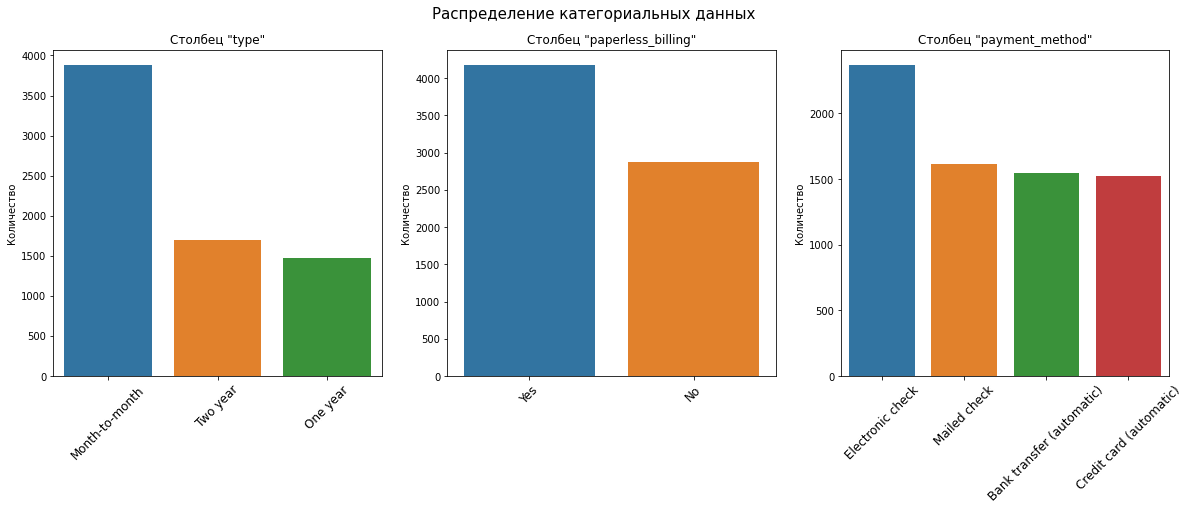

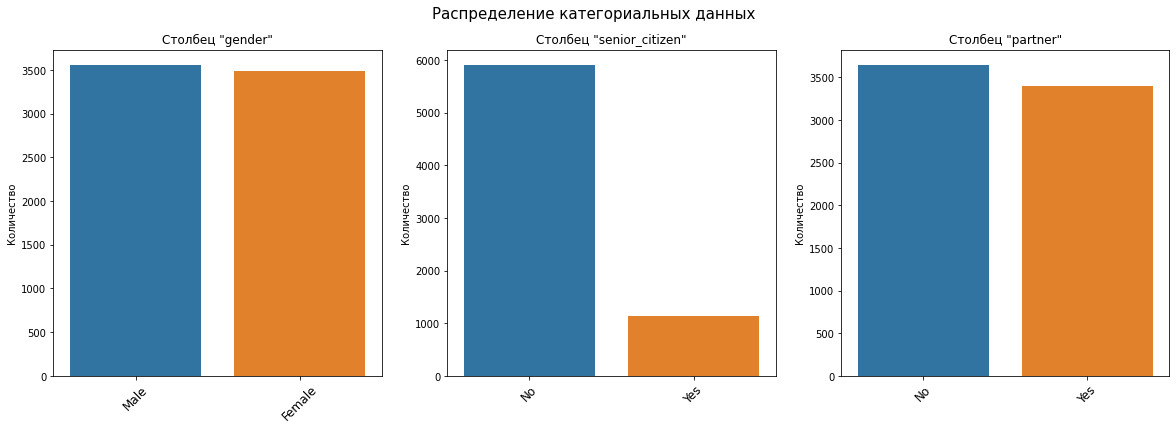

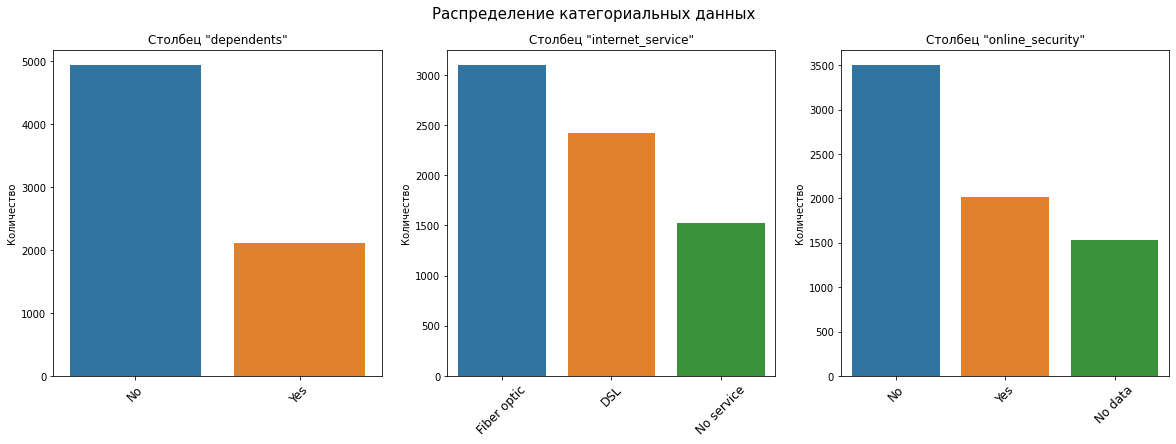

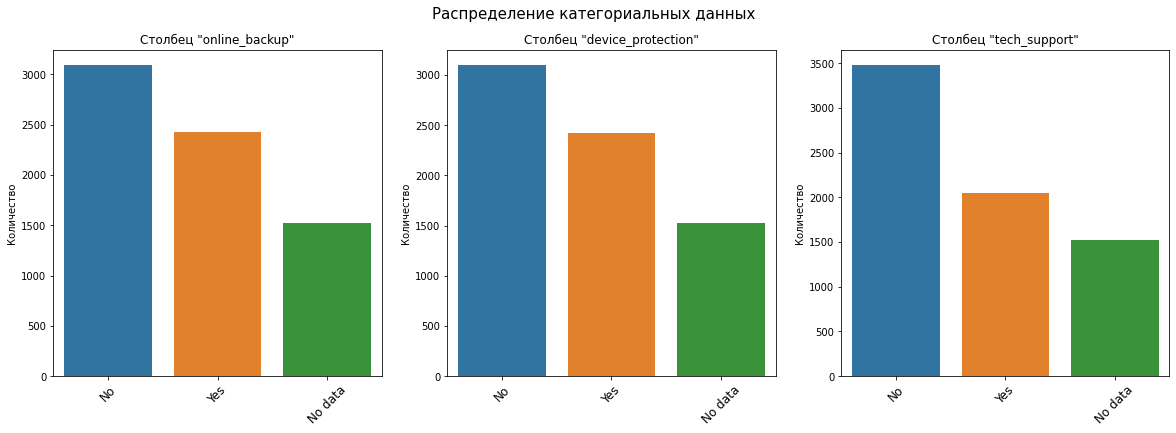

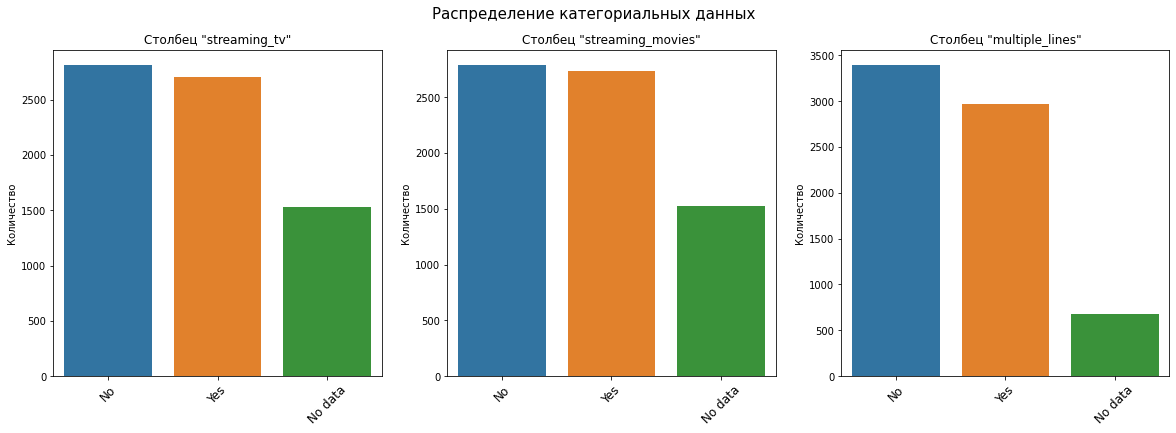

In [48]:
for i in range(0, 15, 3):
    cols = cat_columns[i:]
    cols = cols[:3]
    graf_cat_info(df, cols)

**Вывод:**

- самый популярный способ оплаты - помесячный;
- абоненты предпочитают получать электронный расчётный лист;
- оплата при помощи электронного чека преобладает над другими видами;
- гендерное распределение абонентов - одинаковое;
- соотношение пенсионеров к остальным возрастам примерно 1 к 6;
- в качестве интернет соединения абоненты выбирают оптоволокно;
- интернет сервисы не пользуются популярностью, но сервисы из категории "streaming" приобераются каждым вторым абонентом, использующим интернет;
- абоненты с подключенной телефонной линией предпочитают не устанавливать подключение к нескольким линиям одновременно.

#### Анализ числовых признаков

Выберем столбцы с числовыми данными и выведем графики:

In [49]:
num_columns = df.select_dtypes(include=['float', 'int']).columns.to_list()
num_columns.remove('churn')
#num_columns

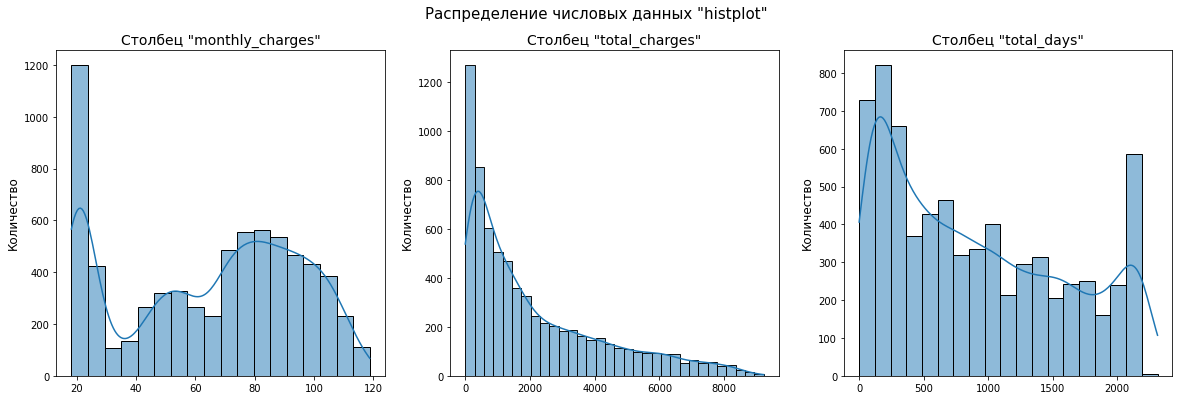

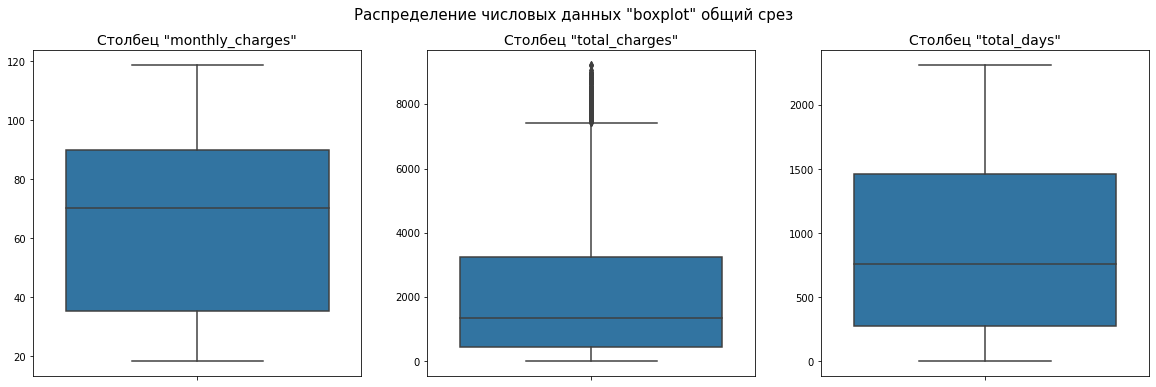

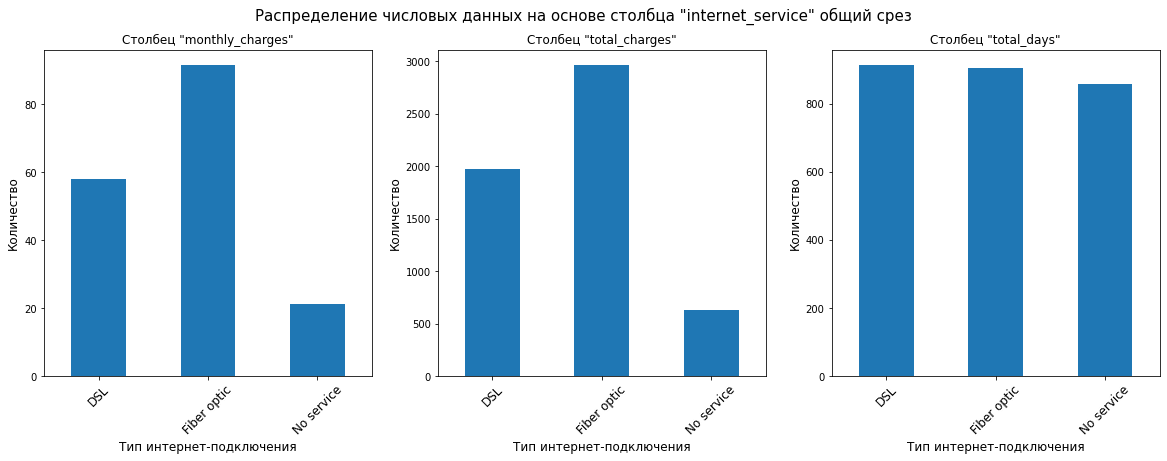

,monthly_charges,total_charges,total_days
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,898.555729
std,30.090047,2112.742814,683.130510
min,18.250000,0.000000,0.000000
25%,35.500000,436.750000,276.000000
50%,70.350000,1343.350000,761.000000
75%,89.850000,3236.690000,1461.000000
max,118.750000,9221.380000,2314.000000


In [50]:
hist_num_info(df, num_columns)
box_num_info(df, num_columns, ' общий срез')
graf_num_info(df, num_columns, ' общий срез')
df[num_columns].describe() 

**Вывод:**

- на гистограмме столбца `monthly_charges` есть несколько пиков, которые образовываются на основе типа подключения абонента:
    - без интернета - в среднем 20 долларов;
    - DSL - 60 долларов;
    - Оптоволокно - 85 долларов.
- общие расходы абонента увеличиваются пропорционально типу подключения интернета (или его отсутствия);
- график распределения указывает на наличие аномалий в столбце `total_charges`, но это абоненты, которые длительное время пользуются услугами оператора и имеют высокую ежемесячную плату;
- тип подключения интернета или его отсутствие не влияют на решение абонента о расторжении контракта.

### Анализ в данных в разрезе целевого признака

Проведем анализ признаков с разделением по целевому признаку `churn`:

#### Анализ категориальных признаков

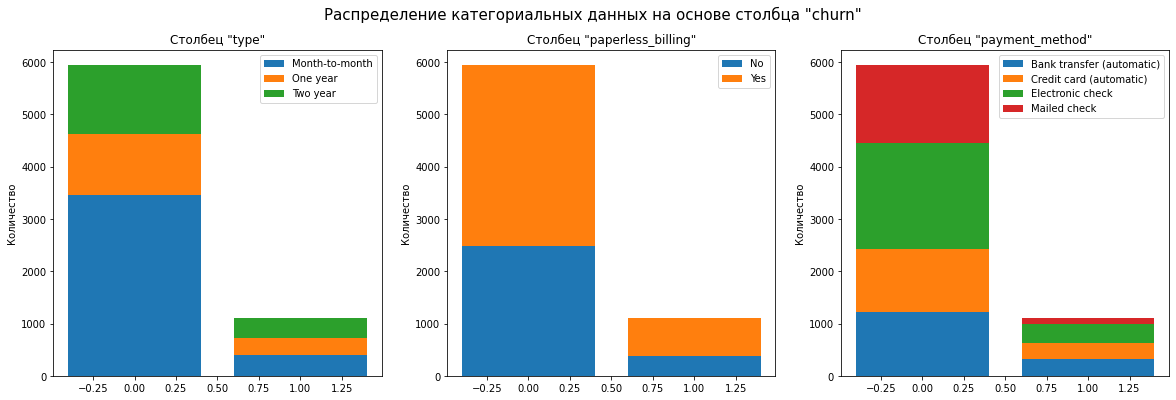

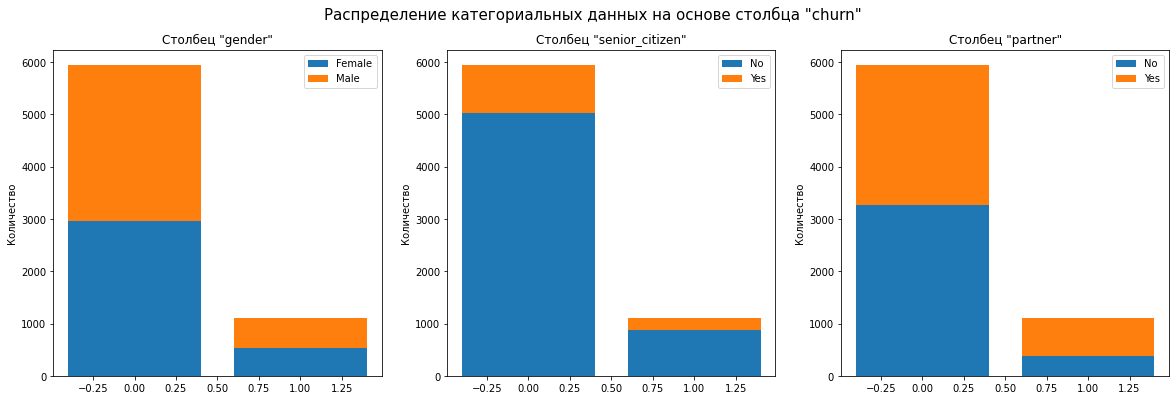

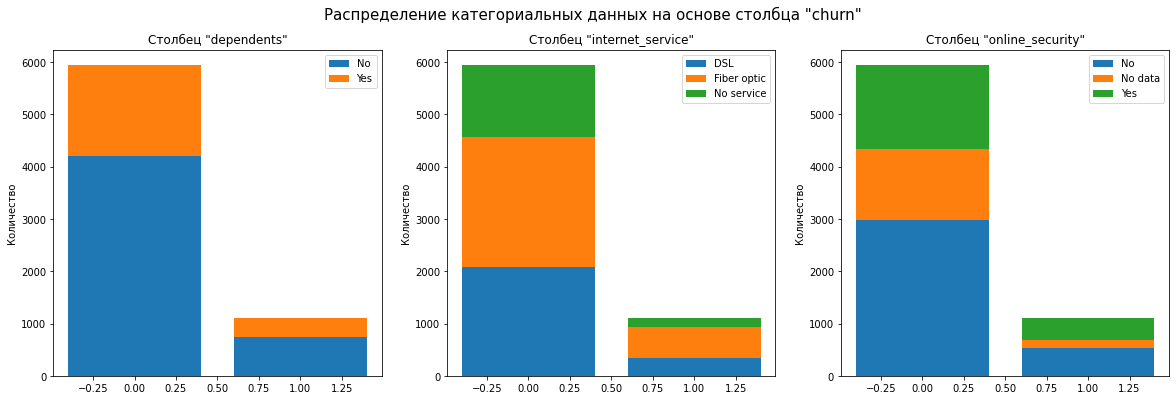

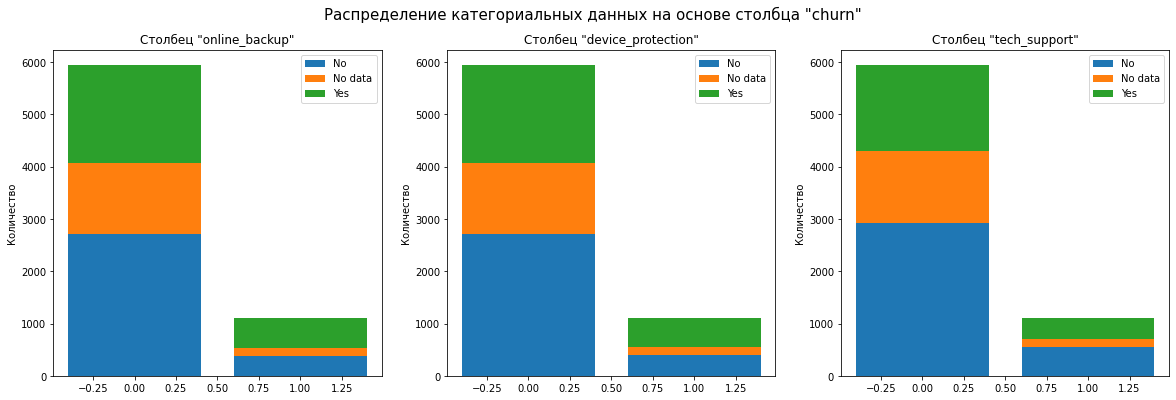

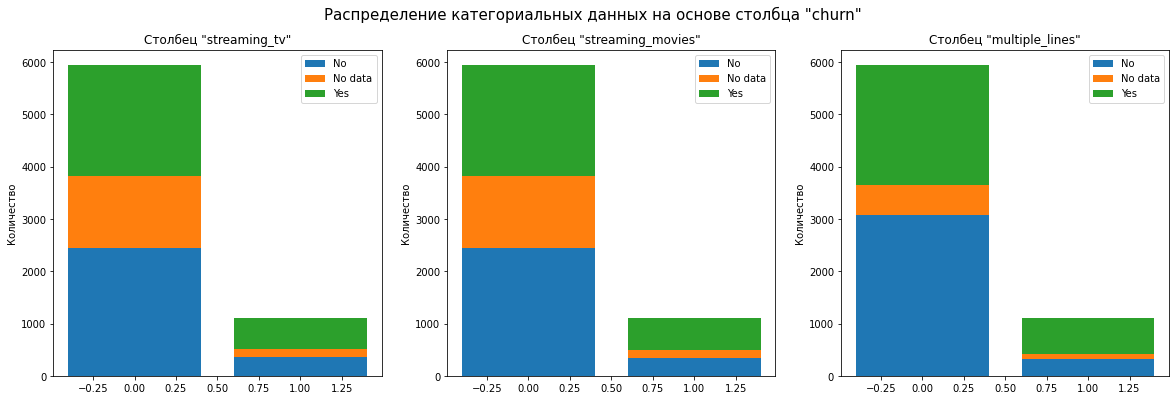

In [51]:
for i in range(0, 15, 3):
    cols = cat_columns[i:]
    cols = cols[:3]
    churn_cat_info(df, cols)

**Вывод:**

- тип оплаты не влияет на решение о расторжении контракта;
- на основе графиков можно сделать вывод, что абоненты с дополнительными услугами для интернета и телефонии чаще расторгают контракт. Возможно дело в качестве предлагаемых дополнительных услуг или в соотношении цена-качество тех же услуг.

#### Анализ числовых признаков

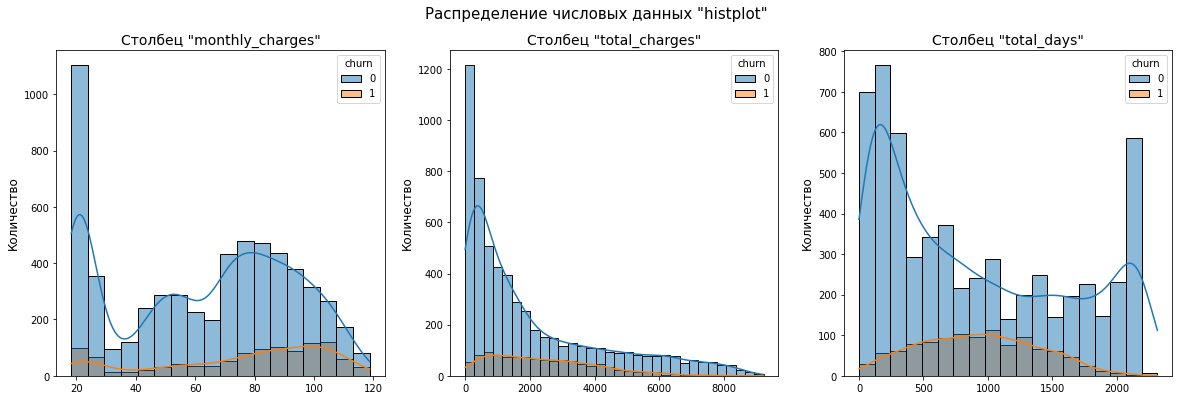

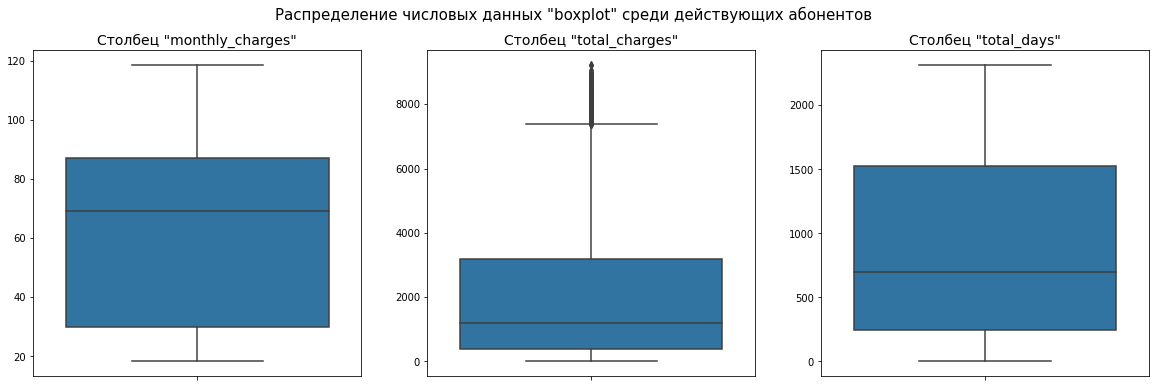

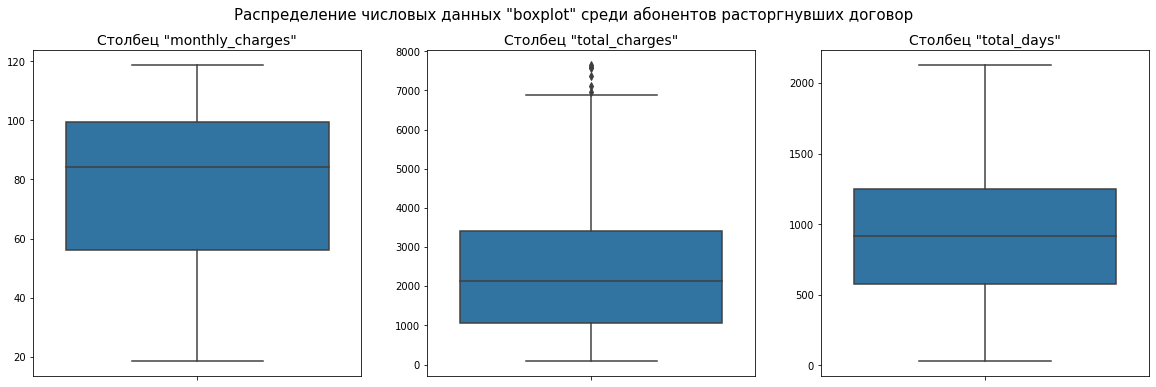

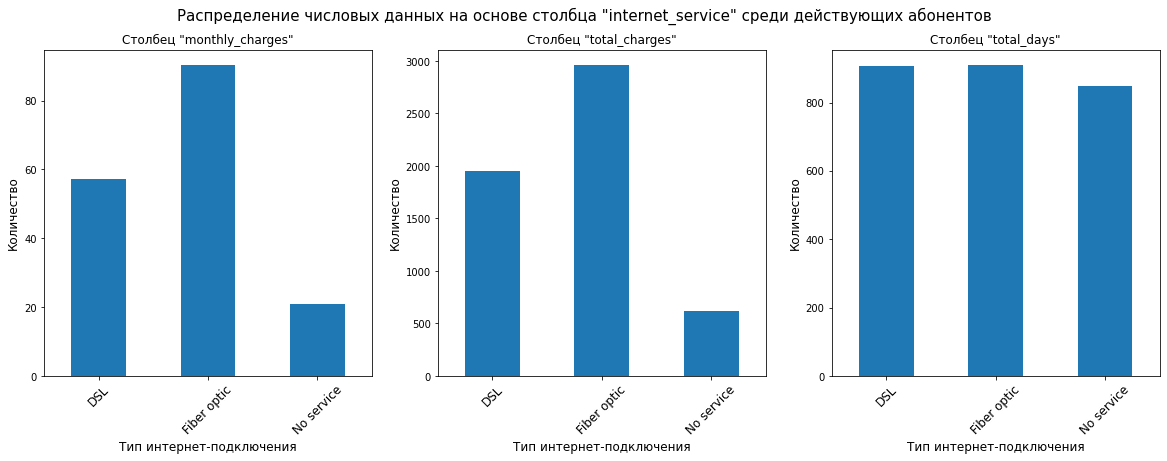

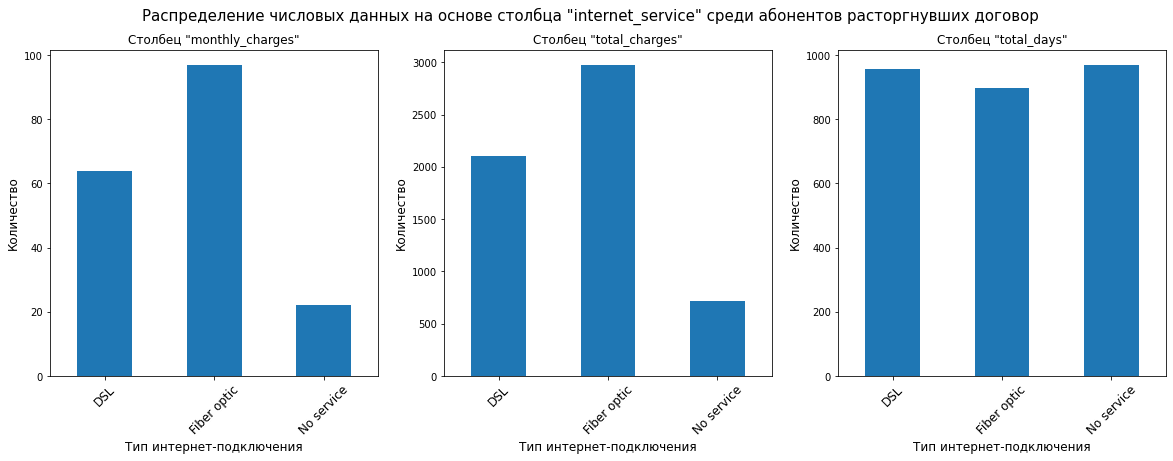

,monthly_charges,total_charges,churn,total_days
count,5942.000000,5942.000000,5942.0,5942.000000
mean,62.763455,2067.866420,0.0,893.681084
std,29.844462,2193.898483,0.0,716.958551
min,18.250000,0.000000,0.0,0.000000
25%,30.062500,374.352500,0.0,245.000000
50%,69.200000,1192.800000,0.0,702.000000
75%,87.237500,3173.837500,0.0,1523.000000
max,118.600000,9221.380000,0.0,2314.000000


,monthly_charges,total_charges,churn,total_days
count,1101.000000,1101.000000,1101.0,1101.000000
mean,75.546004,2371.377275,1.0,924.863760
std,29.116213,1581.862275,0.0,458.771309
min,18.400000,77.840000,1.0,28.000000
25%,56.150000,1048.050000,1.0,577.000000
50%,84.200000,2139.030000,1.0,915.000000
75%,99.500000,3404.910000,1.0,1249.000000
max,118.750000,7649.760000,1.0,2129.000000


In [52]:
hist_num_info(df, num_columns, 'churn')
box_num_info(df[df['churn'] == 0], num_columns, ' среди действующих абонентов')
box_num_info(df[df['churn'] == 1], num_columns, ' среди абонентов расторгнувших договор')
graf_num_info(df[df['churn'] == 0], num_columns, ' среди действующих абонентов')
graf_num_info(df[df['churn'] == 1], num_columns, ' среди абонентов расторгнувших договор')
display(df[df['churn'] == 0].describe())
df[df['churn'] == 1].describe() 

**Вывод:**

- тип подключения интернета или его отсутствие не влияют на решение абонента о расторжении договора с точки зрения ежемесячного платежа, общих расходов абонента или длительности пользования услуг;
- пиковая вероятность расторжения контракта наступает в среднем через 3 года после заключения. Далее вероятность снижается.

### Корреляция признаков

Для проверки корреляции признаков будем использовать библиотеку `phik`:

In [53]:
phik_m = df.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'total_days'])
phik_m

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,total_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
begin_date,1.000000,0.548313,0.766249,0.081447,0.456389,0.421886,0.774207,0.450254,0.978521,0.011268,0.050862,0.473514,0.208564,0.192197,0.460712,0.496176,0.502422,0.455418,0.419599,0.431137,0.468035
end_date,0.548313,1.000000,0.285429,0.062936,0.169262,0.173493,0.217670,1.000000,0.396342,0.018274,0.090502,0.177492,0.055518,0.117099,0.166235,0.236373,0.225828,0.150303,0.185980,0.199118,0.249504
type,0.766249,0.285429,1.000000,0.106860,0.277462,0.388444,0.470860,0.094015,0.634155,0.000000,0.086231,0.179736,0.147680,0.505187,0.636884,0.581660,0.631531,0.671629,0.549564,0.553556,0.244410
paperless_billing,0.081447,0.062936,0.106860,1.000000,0.370495,0.467812,0.201703,0.083398,0.026799,0.000000,0.242133,0.013218,0.172593,0.231438,0.208320,0.195321,0.195687,0.200621,0.204717,0.202241,0.099953
payment_method,0.456389,0.169262,0.277462,0.370495,1.000000,0.399526,0.335666,0.214832,0.350964,0.000000,0.292725,0.243008,0.224903,0.323886,0.315799,0.293413,0.297923,0.317713,0.284531,0.285525,0.174849
monthly_charges,0.421886,0.173493,0.388444,0.467812,0.399526,1.000000,0.710905,0.226280,0.387727,0.008175,0.304985,0.203545,0.184366,0.919002,0.812632,0.818851,0.827272,0.816660,0.864677,0.863616,0.709983
total_charges,0.774207,0.217670,0.470860,0.201703,0.335666,0.710905,1.000000,0.302890,0.848337,0.000000,0.135650,0.381958,0.084247,0.490081,0.516538,0.550544,0.558393,0.527838,0.555322,0.554030,0.467787
churn,0.450254,1.000000,0.094015,0.083398,0.214832,0.226280,0.302890,1.000000,0.374569,0.008581,0.086159,0.226688,0.046871,0.056621,0.058659,0.089704,0.085608,0.051537,0.078545,0.086577,0.105101
total_days,0.978521,0.396342,0.634155,0.026799,0.350964,0.387727,0.848337,0.374569,1.000000,0.000000,0.063315,0.453688,0.198729,0.060845,0.346398,0.366170,0.374702,0.353438,0.306675,0.307297,0.347289
gender,0.011268,0.018274,0.000000,0.000000,0.000000,0.008175,0.000000,0.008581,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.001460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Теперь выведем данные в виде графика:

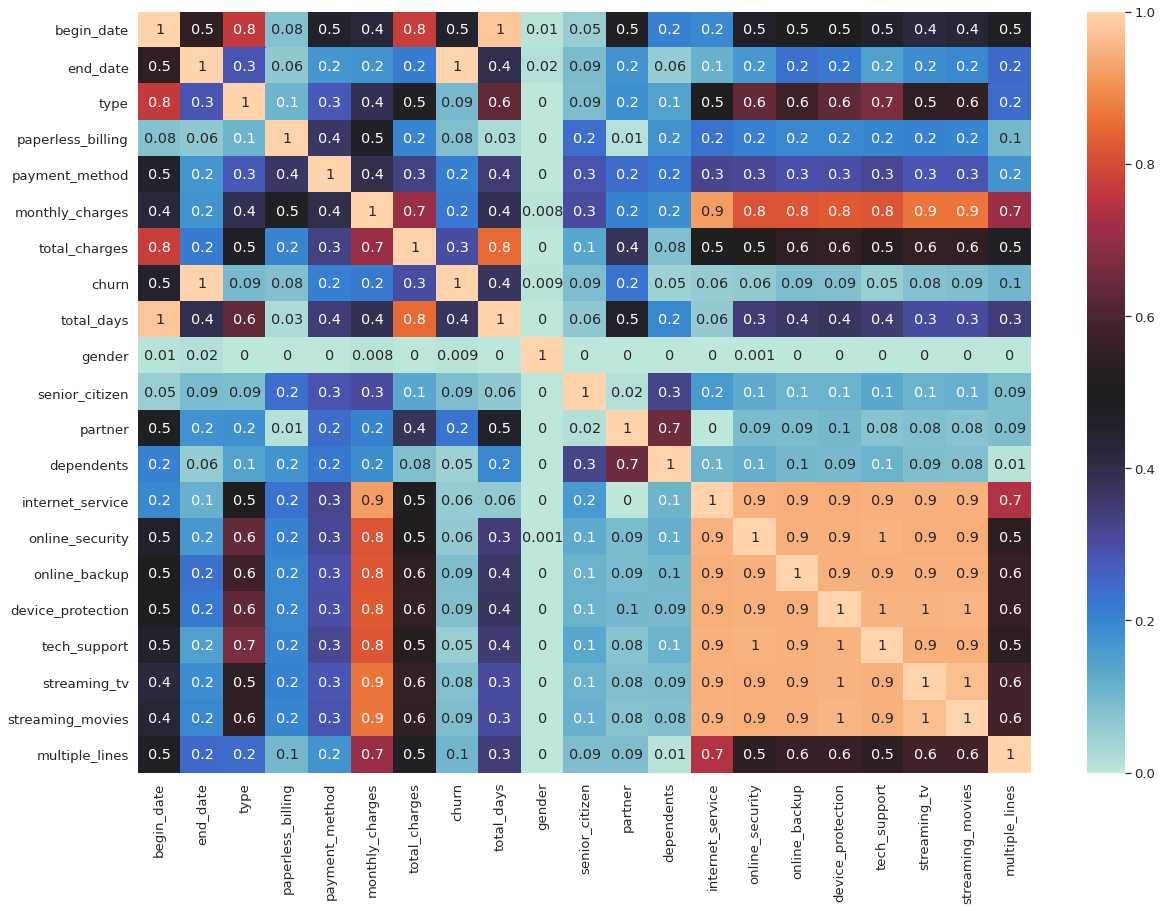

In [54]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(20, 14))
sns.heatmap(phik_m, annot=True, vmin=0, vmax=1, center= 0.5, fmt='.1g')

plt.show()

**Вывод:**

- наибольшая корреляция между признаками, которые являются дополнительными опциями при подключении интернета:
    - internet_service;
    - online_security;
    - online_backup;
    - device_protection;
    - tech_support;
    - streaming_tv;
    - streaming_movies.
- расходы в месяц `monthly_charges` также сильно коррелируют с доп. опциями;
- имеется так же вполне логичная корреляция между кол-вом дней и общими расходами;
- с целевым признаком небольшая корреляция есть только у даты начала действия договора и общим кол-во дней;
- наименьшая корреляция с остальными признаками у `gender`.

## Подготовка данных

Датасет подготовлен, теперь удалим признаки относящиеся к времени и выделим отдельно целевой признак. Также разделим на обучающую и тестовую выборки:

In [55]:
features = df.drop(['churn', 'begin_date', 'end_date'], axis=1)
target = df['churn']

f_train, f_test, t_train, t_test = train_test_split(features,
                                                    target,
                                                    test_size=.25,
                                                    stratify=target,
                                                    random_state=STATE)

Проверим кол-во строк в обучающей выборке:

In [56]:
f_train.shape, t_train.shape

((5282, 18), (5282,))

Обучим `OneHotEncoder` и трансформируем категориальные признаки:

In [57]:
def encod_OHE(encod, df):
    encod_df = df.copy()
    try:
        encod_df[encod.get_feature_names_out()] = encod.transform(df[cat_col])
    except:
        encod_df[encod.get_feature_names()] = encod.transform(df[cat_col])
    encod_df = encod_df.drop(cat_col, axis=1)
    
    return encod_df

In [58]:
cat_col = f_train.select_dtypes(include='object').columns.to_list()

encoder_OHE = OneHotEncoder(drop='first', sparse=False)
encoder_OHE.fit(f_train[cat_col])

OneHotEncoder(drop='first', sparse=False)

In [59]:
ohe_f_train = encod_OHE(encoder_OHE, f_train)
ohe_f_test = encod_OHE(encoder_OHE, f_test)

Для численных признаков используем масштабирование `StandardScaler`:

In [60]:
scaler = StandardScaler()

ohe_f_train[num_columns] = scaler.fit_transform(ohe_f_train[num_columns])
ohe_f_test[num_columns] = scaler.transform(ohe_f_test[num_columns])

Проверим уол-во признаков в обеих выборках:

In [61]:
ohe_f_train.shape, ohe_f_test.shape

((5282, 29), (1761, 29))

Выведем 5 случайных строк из обучающей выборки:

In [62]:
ohe_f_train.sample(5)

,monthly_charges,total_charges,total_days,x0_One year,x0_Two year,x1_Yes,x2_Credit card (automatic),x2_Electronic check,x2_Mailed check,x3_Male,x4_Yes,x5_Yes,x6_Yes,x7_Fiber optic,x7_No service,x8_No data,x8_Yes,x9_No data,x9_Yes,x10_No data,x10_Yes,x11_No data,x11_Yes,x12_No data,x12_Yes,x13_No data,x13_Yes,x14_No data,x14_Yes
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6248-TKCQV,0.530428,1.922934,1.808488,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2277-VWCNI,-0.528140,-0.899162,-1.125477,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1197-BVMVG,0.326027,-0.836920,-1.125477,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5469-CTCWN,1.374625,1.746318,1.138160,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3224-DFQNQ,0.809611,0.985631,0.605110,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


**Вывод:**

Выборки подготовлены для обучения модели.

## Обучение моделей машинного обучения

Для обучения модели будем использовать следующую функцию:

In [63]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)

def gridsearch_def(f_train, t_train, model, params):

    start_time = time.time()

    grid = GridSearchCV(model, params, cv=4, n_jobs=-1, scoring=roc_auc_scorer, error_score='raise')

    grid.fit(f_train, t_train)

    finish_time = time.time()
    funtion_time = finish_time - start_time

    table = PrettyTable()
    table.field_names = ['Данные', 'Значение']
    table.add_row(['Обучение модели', f'{funtion_time // 60} мин \n{(funtion_time % 60):.2f} сек'])
    table.add_row([' ', ' '])
    table.add_row(['ROC-AUC', f'{grid.best_score_}'])
    table.add_row([' ', ' '])
    table.add_row(['Лучшие параметры:', ' '])
    for k, v in grid.best_params_.items():
        table.add_row([f'{k}:', v])
    print(table)


    return grid, funtion_time

### LogisticRegression

In [64]:
params = {
    'class_weight':['balanced'],
    'solver': ('newton-cg', 'lbfgs', 'liblinear'),
    'C': (0.001, 0.01, 0.1, 1, 10, 100, 1000)
}

logr_grid, logr_times = gridsearch_def(ohe_f_train, t_train, LogisticRegression(random_state=STATE), params)

+-------------------+--------------------+
|       Данные      |      Значение      |
+-------------------+--------------------+
|  Обучение модели  |      0.0 мин       |
|                   |     38.60 сек      |
|                   |                    |
|      ROC-AUC      | 0.7587379767016901 |
|                   |                    |
| Лучшие параметры: |                    |
|         C:        |         1          |
|   class_weight:   |      balanced      |
|      solver:      |     newton-cg      |
+-------------------+--------------------+


### RandomForestClassifier

In [65]:
params = {
    'class_weight':['balanced'],
    'n_estimators':[x for x in range(10,201,10)],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    'max_depth':[x for x in range(10,101,2)]
}

rfc_grid, rfc_times = gridsearch_def(ohe_f_train, t_train, RandomForestClassifier(random_state=STATE), params)

+--------------------+--------------------+
|       Данные       |      Значение      |
+--------------------+--------------------+
|  Обучение модели   |     94.0 мин       |
|                    |     46.02 сек      |
|                    |                    |
|      ROC-AUC       | 0.8176460335672628 |
|                    |                    |
| Лучшие параметры:  |                    |
|   class_weight:    |      balanced      |
|     max_depth:     |         10         |
| min_samples_leaf:  |         10         |
| min_samples_split: |         2          |
|   n_estimators:    |        170         |
+--------------------+--------------------+


### CatBoostClassifier

In [66]:
params = {
    'auto_class_weights':['Balanced'],
    'learning_rate':[0.1, 0.5, 0.8],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [3, 9],
    'iterations': [50, 100]
}

cbc_grid, cbc_times = gridsearch_def(ohe_f_train, t_train, CatBoostClassifier(random_state=290124, verbose=False), params)

+---------------------+--------------------+
|        Данные       |      Значение      |
+---------------------+--------------------+
|   Обучение модели   |      3.0 мин       |
|                     |     17.58 сек      |
|                     |                    |
|       ROC-AUC       | 0.8839535701267038 |
|                     |                    |
|  Лучшие параметры:  |                    |
| auto_class_weights: |      Balanced      |
|        depth:       |         4          |
|     iterations:     |        100         |
|     l2_leaf_reg:    |         3          |
|    learning_rate:   |        0.5         |
+---------------------+--------------------+


### Обобщение результатов

In [67]:
data = {'ROC-AUC на валидационных данных':[logr_grid.best_score_,
                                           rfc_grid.best_score_,
                                           cbc_grid.best_score_],

        'Время обучения модели, сек.':[logr_times,
                                       rfc_times,
                                       cbc_times]}

index = ['LogisticRegression',
         'RandomForestClassifier',
         'CatBoostClassifier']

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['ROC-AUC на валидационных данных'] >= 0.85
scores_data

,ROC-AUC на валидационных данных,"Время обучения модели, сек.",Выполнение задачи
LogisticRegression,0.758738,38.602484,False
RandomForestClassifier,0.817646,5686.018440,False
CatBoostClassifier,0.883954,197.577707,True


**Вывод:**

Наилучшим показателем `ROC-AUC` на обучающей выборке при кросс-валидации обладает модель `CatBoostClassifier` с результатом 0.884. Остальные модели не соответствуют условиям заказчика в показатель `ROC-AUC` более 0.85.

## Выбор лучшей модели

Протестируем лучшую модель на тестовой выборке и выведем график:

ROC-AUC: 0.9072580447815979
F1: 0.6272189349112426
accuracy: 0.8568994889267462


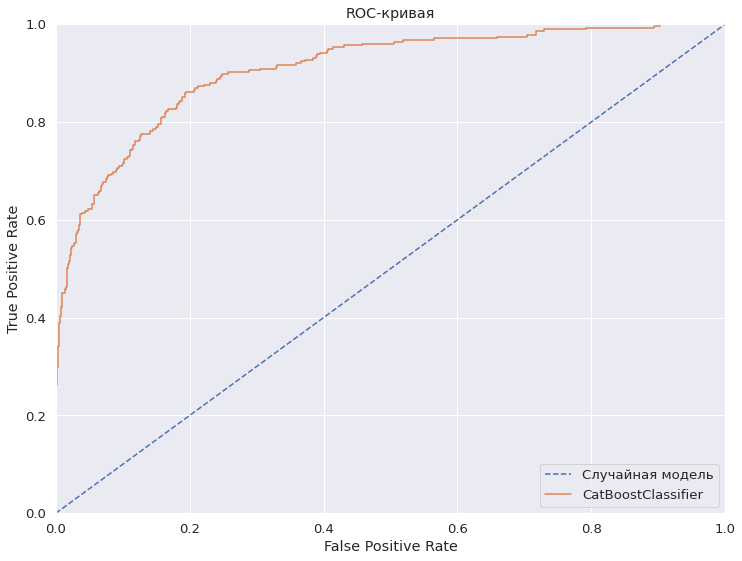

CPU times: user 199 ms, sys: 7.99 ms, total: 207 ms
Wall time: 204 ms


In [68]:
%%time

plt.figure(figsize=[12,9])
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')

prob_test = cbc_grid.best_estimator_.predict_proba(ohe_f_test)
prob_one_test = prob_test[:, 1]
fpr, tpr, thresholds = roc_curve(t_test, prob_one_test)
plt.plot(fpr, tpr, label='CatBoostClassifier')
print('ROC-AUC:', roc_auc_score(t_test, prob_one_test))
print('F1:', f1_score(t_test, cbc_grid.best_estimator_.predict(ohe_f_test)))
print('accuracy:', accuracy_score(t_test, cbc_grid.best_estimator_.predict(ohe_f_test)))

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right')

plt.title("ROC-кривая")
plt.show()

`CatBoostClassifier` на тестовой выборке показал следующие результаты:
- `ROC-AUC`: 0.907;
- `Accuracy`: 0.857;
- `F1`: 0.627.

Выведем матрицу ошибок нашей модели:

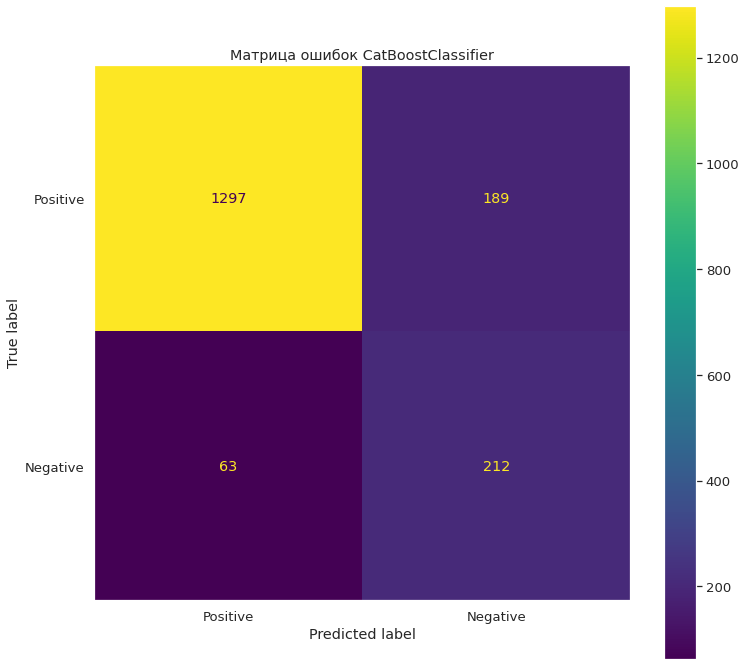

In [69]:
cm = confusion_matrix(t_test, cbc_grid.best_estimator_.predict(ohe_f_test))
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Negative"]).plot(ax=ax)

plt.title('Матрица ошибок CatBoostClassifier')
ax.grid(False)

plt.show()

Матрица ошибок показывает, что в большинстве случаев модель правильно предсказывает.

Проведем анализ важности признаков и выведем график:

In [70]:
importances_df = pd.DataFrame(cbc_grid.best_estimator_.feature_importances_, index = ohe_f_test.columns, columns=['importances'])
importances_df = importances_df.sort_values(by='importances', ascending=False)
importances_df

,importances
total_days,60.826760
total_charges,9.912242
monthly_charges,9.193928
x0_Two year,4.509865
x5_Yes,2.065268
x0_One year,1.652637
x14_Yes,1.292211
x2_Mailed check,1.190713
x6_Yes,1.163649
x2_Credit card (automatic),1.053435


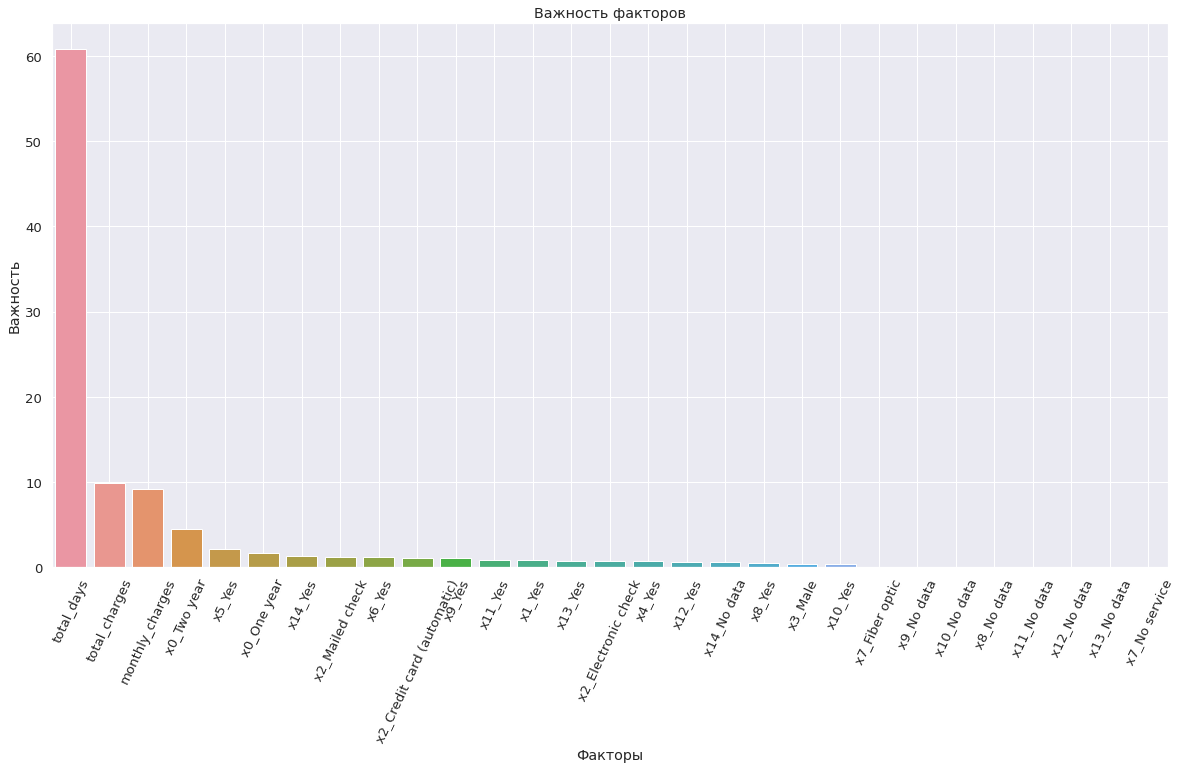

In [71]:
plt.figure(figsize=(20,10))

sns.barplot(x=importances_df.index, y=importances_df['importances'])
plt.title('Важность факторов')
plt.xticks(rotation=65)
plt.xlabel('Факторы')
plt.ylabel('Важность')
plt.grid(True)

plt.show()

Наиболее важным признаком оказался `total_days` (продолжительность договора в днях). Также важными признаками являются `total_charges` (общие расходы абонента) и `monthly_charges` (расходы за месяц). Изменение данных признаков окажет значительное влияние на предсказание модели. Остальные признаки не оказывают сильное влияние на предсказание модели.

## Общий вывод и рекомендации заказчику

Предобработка данных:
- загрузили данные;
- привели названия столбцов к общему стилю;
- создали признак и целевой признак;
- привели в соответствие типы столбцов;
- объединили датасеты в один на основе `customer_id`;
- отсутствующие значения в столбце `internet_service` заменили на значение `No service`;
- в остальных столбцах заменили отсутствующие значения на `No data`.

Исследовательский анализ:
- рассмотрены графики распределения признаков для объединенного датасета;
- рассмотрены графики распределения признаков в соотношении действующих и расторгнувших контракт абонентов;
- построена матрица корреляции `phik`;

Обучены модели:
- `LogisticRegression`;
- `RandomForestClassifier`;
- `CatBoostClassifier`;
- проанализировано качество каждой модели.

Тестирование лучшей модели:
- в качестве лучшей модели выбрана модель `CatBoostClassifier`;
- построена `ROC-кривая`;
- результаты тестирования:
    - `ROC-AUC`: 0.907;
    - `Accuracy`: 0.857;
    - `F1`: 0.627.
- построена и проанализирована матрица ошибок;
- построен и проанализирован график важности признаков.

**Рекомендации:**

Обратить внимание на качество предоставляемых дополнительных услуг (мультиканальность для телефонии и интернет сервисы). Около 50% абонентов расторгнувших договор пользовались данными услугами. Возможно конкуренты предлагают более качественные услуги за ту же цену. Стоит обратить внимание на жалобы на данные услуги в тех.поддержку для возможного решения проблемы.